# Scouting Classification using Machine Learning Algorithms

# Business Problem

📌 Predicting which class (average, highlighted) players are according to the scores given to the characteristics of the football players watched by the Scouts.

# Dataset Story

📌 The data set consists of information from Scoutium, which includes the features and scores of the football players evaluated by the scouts according to the characteristics of the footballers observed in the matches.


# Import Necessary Libraries

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats

pd.set_option("display.max_columns",None)
pd.set_option("display.width",500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier

!pip install xgboost
!pip install lightgbm
!pip install catboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Dataset

In [13]:
df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/scoutium_potential_labels.csv", sep=";")
df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/scoutium_attributes.csv", sep=";")
df = pd.merge(df1, df2, on=['task_response_id', 'match_id', 'evaluator_id', 'player_id'], how='left')
df.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,average,2,12818495,4322,56.0000
1,4915,62935,177676,1361061,average,2,12818495,4323,56.0000
2,4915,62935,177676,1361061,average,2,12818495,4324,67.0000
3,4915,62935,177676,1361061,average,2,12818495,4325,56.0000
4,4915,62935,177676,1361061,average,2,12818495,4326,45.0000


# General Information About to the Dataset

In [14]:
def check_df(dataframe,head=5):
  print("######################### Head #########################")
  print(dataframe.head(head))
  print("######################### Tail #########################")
  print(dataframe.tail(head))
  print("######################### Shape #########################")
  print(dataframe.shape)
  print("######################### Types #########################")
  print(dataframe.dtypes)
  print("######################### NA #########################")
  print(dataframe.isnull().sum())
  print("######################### Qurtiles #########################")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [15]:
check_df(df)

######################### Head #########################
   task_response_id  match_id  evaluator_id  player_id potential_label  position_id  analysis_id  attribute_id  attribute_value
0              4915     62935        177676    1361061         average            2     12818495          4322          56.0000
1              4915     62935        177676    1361061         average            2     12818495          4323          56.0000
2              4915     62935        177676    1361061         average            2     12818495          4324          67.0000
3              4915     62935        177676    1361061         average            2     12818495          4325          56.0000
4              4915     62935        177676    1361061         average            2     12818495          4326          45.0000
######################### Tail #########################
       task_response_id  match_id  evaluator_id  player_id potential_label  position_id  analysis_id  attribute_id  at

# Analysis of Categorical and Numerical Variables

In [16]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  #Catgeorical Variable Selection
  cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category","object","bool"]]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8","int64","float64"]]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category","object"]]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  #Numerical Variable Selection
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8","int64","float64"]]
  num_cols = [col for col in num_cols if col not in cat_cols]

  return cat_cols, num_cols, cat_but_car

In [17]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

#Print Categorical and Numerical Variables
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Cat_cols: {len(cat_cols)}")
print(f"Num_cols: {len(num_cols)}")
print(f"Cat_but_car: {len(cat_but_car)}")

Observations: 10730
Variables: 9
Cat_cols: 1
Num_cols: 8
Cat_but_car: 0


In [18]:
def cat_summary(dataframe,col_name,plot=False):
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      'Ration': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
  print("##########################################")
  if plot:
    sns.countplot(x=dataframe[col_name],data=dataframe)
    plt.show(block=True)

In [19]:
def cat_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car = grab_col_names(df)
  for col in cat_cols:
    cat_summary(dataframe, col, plot=True)

               potential_label  Ration
average                   8497 79.1892
highlighted               2097 19.5433
below_average              136  1.2675
##########################################


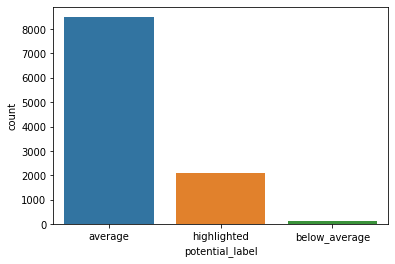

In [20]:
cat_summary_df(df)

In [21]:
def num_summary(dataframe, num_col, plot=False):
  quantiles = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[num_col].describe(quantiles).T)

  if plot:
    dataframe[num_col].hist(bins=20)
    plt.xlabel(num_col)
    plt.title(num_col)
    plt.show(block=True)

In [22]:
def num_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car = grab_col_names(df)
  for col in num_cols:
    num_summary(dataframe, col, plot=True)

count   10730.0000
mean     5252.0824
std       268.2540
min      4915.0000
1%       4915.0000
5%       4919.0000
10%      4929.0000
20%      4970.0000
30%      5005.0000
40%      5119.0000
50%      5162.0000
60%      5319.0000
70%      5523.0000
80%      5579.0000
90%      5621.0000
95%      5639.0000
99%      5642.0000
max      5642.0000
Name: task_response_id, dtype: float64


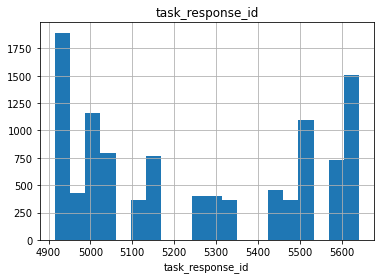

count   10730.0000
mean    63199.7641
std       663.9166
min     60549.0000
1%      60549.0000
5%      61923.0000
10%     62935.0000
20%     62944.0000
30%     63032.0000
40%     63058.0000
50%     63166.0000
60%     63406.0000
70%     63556.0000
80%     63696.0000
90%     63930.0000
95%     64045.0000
99%     64045.0000
max     64045.0000
Name: match_id, dtype: float64


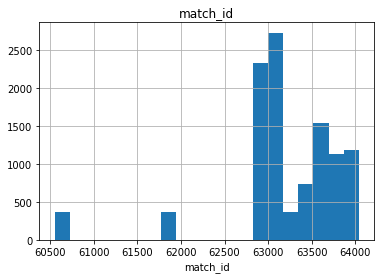

count    10730.0000
mean    175246.8800
std      43667.4593
min     130478.0000
1%      130478.0000
5%      132337.0000
10%     132337.0000
20%     151191.0000
30%     151191.0000
40%     151191.0000
50%     151191.0000
60%     160289.0000
70%     177676.0000
80%     256441.0000
90%     256441.0000
95%     256441.0000
99%     256441.0000
max     256441.0000
Name: evaluator_id, dtype: float64


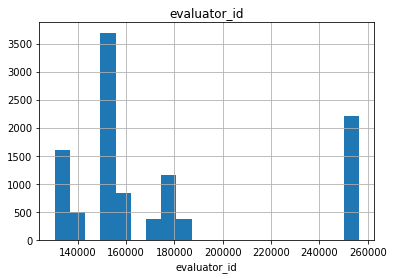

count     10730.0000
mean    1525548.4861
std      201751.8749
min     1355710.0000
1%      1356375.0000
5%      1359357.0000
10%     1361221.0000
20%     1367211.0000
30%     1369065.0000
40%     1370872.0000
50%     1372670.0000
60%     1438737.0000
70%     1717707.0000
80%     1783081.0000
90%     1805970.0000
95%     1844969.0000
99%     1907347.0000
max     1909728.0000
Name: player_id, dtype: float64


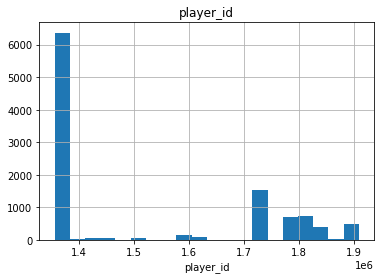

count   10730.0000
mean        5.3474
std         2.8612
min         1.0000
1%          1.0000
5%          1.0000
10%         2.0000
20%         2.0000
30%         3.0000
40%         4.0000
50%         6.0000
60%         6.0000
70%         7.0000
80%         8.0000
90%        10.0000
95%        10.0000
99%        10.0000
max        10.0000
Name: position_id, dtype: float64


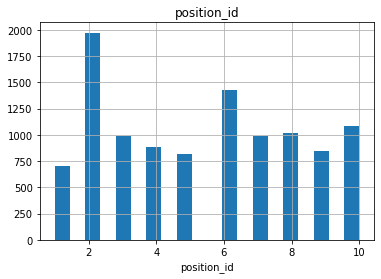

count      10730.0000
mean    12822388.7996
std         2676.8660
min     12818481.0000
1%      12818492.0000
5%      12818552.0000
10%     12818771.0000
20%     12819199.0000
30%     12819739.0000
40%     12821971.0000
50%     12822231.0000
60%     12823686.0000
70%     12825024.0000
80%     12825303.0000
90%     12825548.0000
95%     12825724.0000
99%     12825761.0000
max     12825764.0000
Name: analysis_id, dtype: float64


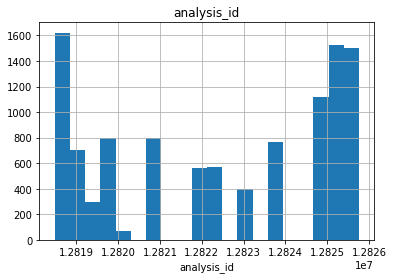

count   10730.0000
mean     4348.6089
std        26.9800
min      4322.0000
1%       4322.0000
5%       4323.0000
10%      4325.0000
20%      4328.0000
30%      4332.0000
40%      4339.0000
50%      4342.0000
60%      4348.0000
70%      4351.0000
80%      4355.0000
90%      4407.0000
95%      4423.0000
99%      4426.0000
max      4426.0000
Name: attribute_id, dtype: float64


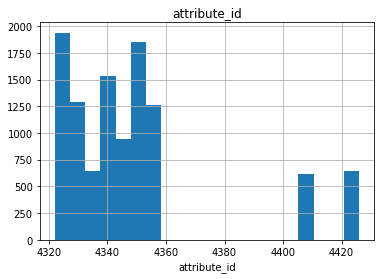

count   10730.0000
mean       55.2711
std        16.0480
min         1.0000
1%         23.0000
5%         23.0000
10%        34.0000
20%        45.0000
30%        45.0000
40%        56.0000
50%        56.0000
60%        67.0000
70%        67.0000
80%        67.0000
90%        78.0000
95%        78.0000
99%        78.0000
max       100.0000
Name: attribute_value, dtype: float64


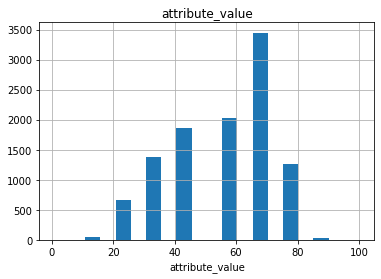

In [23]:
num_summary_df(df)

In [24]:
def plot_num_summary(dataframe):
  cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)
  plt.figure(figsize=(16,6))
  for index, col in enumerate(num_cols):
    plt.subplot(2,4,index+1)
    plt.tight_layout()
    dataframe[col].hist(bins=20)
    plt.title(col)

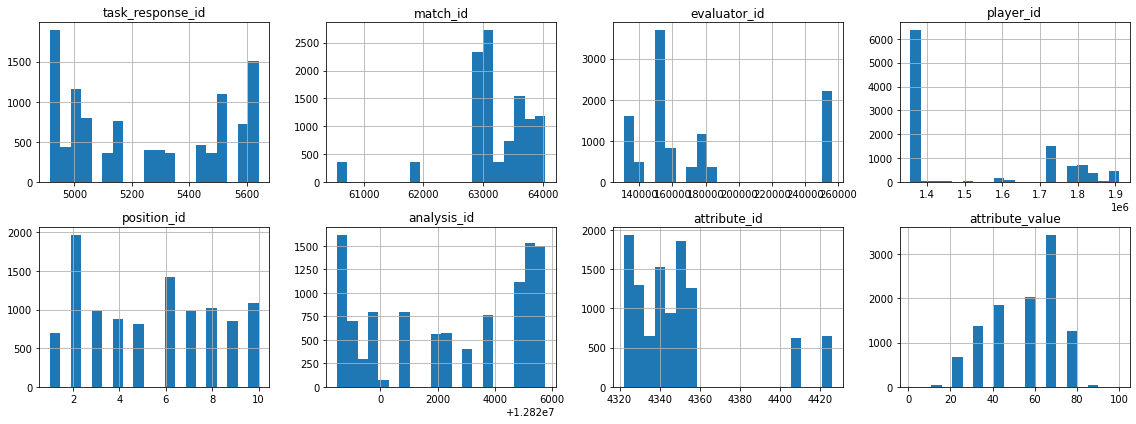

In [25]:
plot_num_summary(df)

# Correlation Analysis

In [26]:
df.corr()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
task_response_id,1.0000,0.1327,0.1533,-0.0858,0.0140,0.9833,0.0000,0.0776
match_id,0.1327,1.0000,-0.0347,-0.3438,0.0037,0.1778,-0.0000,0.0731
evaluator_id,0.1533,-0.0347,1.0000,-0.0771,-0.0097,0.1612,-0.0003,-0.4339
player_id,-0.0858,-0.3438,-0.0771,1.0000,0.0249,-0.1429,0.0004,-0.0079
position_id,0.0140,0.0037,-0.0097,0.0249,1.0000,0.0153,0.0038,0.0098
analysis_id,0.9833,0.1778,0.1612,-0.1429,0.0153,1.0000,0.0000,0.0999
attribute_id,0.0000,-0.0000,-0.0003,0.0004,0.0038,0.0000,1.0000,-0.0137
attribute_value,0.0776,0.0731,-0.4339,-0.0079,0.0098,0.0999,-0.0137,1.0000


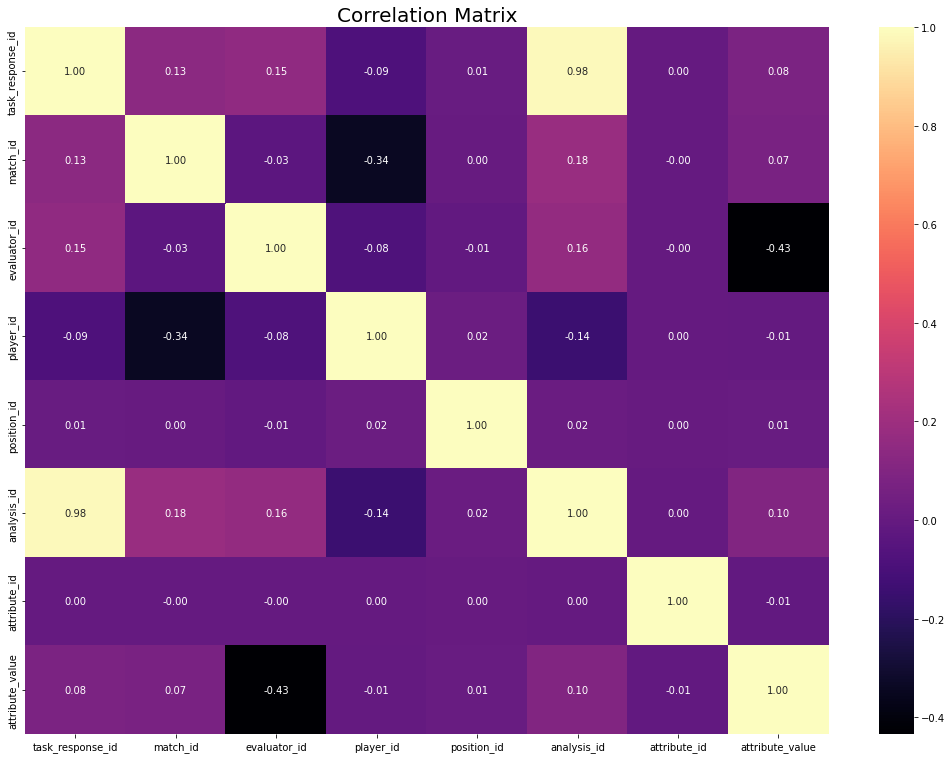

In [27]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

# Missing Value Analysis

In [28]:
df.isnull().sum()

task_response_id    0
match_id            0
evaluator_id        0
player_id           0
potential_label     0
position_id         0
analysis_id         0
attribute_id        0
attribute_value     0
dtype: int64

# Create the Pivot Table

In [29]:
df = df.loc[~(df["position_id"]==1)]
df = df.loc[~(df["potential_label"] == "below_average")]
df = pd.pivot_table(df, values="attribute_value", index=["player_id", "position_id", "potential_label"], columns=["attribute_id"])
df = df.reset_index()
df.columns = df.columns.astype(str)
df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.5000,50.5000,34.0000,50.5000,45.0000,45.0000,45.0000,45.0000,50.5000,56.0000,39.5000,34.0000,39.5000,39.5000,45.0000,45.0000,50.5000,28.5000,23.0000,39.5000,28.5000,28.5000,45.0000,50.5000,56.0000,34.0000,39.5000,50.5000,34.0000,34.0000,56.0000,34.0000,34.0000,56.0000
1,1356362,9,average,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,56.0000,67.0000,67.0000,56.0000,67.0000,67.0000,67.0000,67.0000,78.0000,67.0000,67.0000,67.0000,67.0000,67.0000,56.0000,78.0000
2,1356375,3,average,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,78.0000,67.0000,67.0000,78.0000,56.0000,67.0000,67.0000,67.0000,67.0000,67.0000,56.0000,56.0000,67.0000,67.0000,56.0000,56.0000,67.0000,67.0000,67.0000,78.0000,67.0000,67.0000,67.0000,67.0000,67.0000,56.0000,78.0000
3,1356375,4,average,67.0000,78.0000,67.0000,67.0000,67.0000,78.0000,78.0000,78.0000,56.0000,67.0000,67.0000,67.0000,78.0000,78.0000,56.0000,67.0000,67.0000,45.0000,45.0000,56.0000,67.0000,67.0000,67.0000,67.0000,78.0000,67.0000,67.0000,67.0000,56.0000,67.0000,56.0000,67.0000,45.0000,56.0000
4,1356411,9,average,67.0000,67.0000,78.0000,78.0000,67.0000,67.0000,67.0000,67.0000,89.0000,78.0000,67.0000,67.0000,67.0000,56.0000,56.0000,67.0000,78.0000,56.0000,56.0000,67.0000,56.0000,67.0000,56.0000,67.0000,67.0000,56.0000,67.0000,67.0000,56.0000,67.0000,89.0000,56.0000,67.0000,78.0000


# Encoding Scaling

In [30]:
def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

In [31]:
df = label_encoder(df, "potential_label")

In [32]:
df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,50.5000,50.5000,34.0000,50.5000,45.0000,45.0000,45.0000,45.0000,50.5000,56.0000,39.5000,34.0000,39.5000,39.5000,45.0000,45.0000,50.5000,28.5000,23.0000,39.5000,28.5000,28.5000,45.0000,50.5000,56.0000,34.0000,39.5000,50.5000,34.0000,34.0000,56.0000,34.0000,34.0000,56.0000
1,1356362,9,0,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,56.0000,67.0000,67.0000,56.0000,67.0000,67.0000,67.0000,67.0000,78.0000,67.0000,67.0000,67.0000,67.0000,67.0000,56.0000,78.0000
2,1356375,3,0,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,67.0000,78.0000,67.0000,67.0000,78.0000,56.0000,67.0000,67.0000,67.0000,67.0000,67.0000,56.0000,56.0000,67.0000,67.0000,56.0000,56.0000,67.0000,67.0000,67.0000,78.0000,67.0000,67.0000,67.0000,67.0000,67.0000,56.0000,78.0000
3,1356375,4,0,67.0000,78.0000,67.0000,67.0000,67.0000,78.0000,78.0000,78.0000,56.0000,67.0000,67.0000,67.0000,78.0000,78.0000,56.0000,67.0000,67.0000,45.0000,45.0000,56.0000,67.0000,67.0000,67.0000,67.0000,78.0000,67.0000,67.0000,67.0000,56.0000,67.0000,56.0000,67.0000,45.0000,56.0000
4,1356411,9,0,67.0000,67.0000,78.0000,78.0000,67.0000,67.0000,67.0000,67.0000,89.0000,78.0000,67.0000,67.0000,67.0000,56.0000,56.0000,67.0000,78.0000,56.0000,56.0000,67.0000,56.0000,67.0000,56.0000,67.0000,67.0000,56.0000,67.0000,67.0000,56.0000,67.0000,89.0000,56.0000,67.0000,78.0000


In [33]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if "player_id" not in col]
scaled = StandardScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(scaled, columns=df[num_cols].columns)
df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,-0.5426,-0.5594,34.0000,-0.4379,-0.7666,-0.7948,45.0000,-0.7916,-0.4463,-0.1226,-1.2239,-1.0356,-1.1262,-1.0093,-0.5418,-0.6904,-0.5351,-1.0673,-1.2057,-1.0049,-1.3138,-1.0418,-0.6933,-0.4356,56.0000,-1.2819,-1.1322,-0.4946,-1.2349,34.0000,-0.1426,-1.4873,34.0000,-0.2527
1,1356362,9,0,0.5953,0.5608,67.0000,0.6828,0.7226,0.7229,67.0000,0.4041,0.7280,0.6912,0.4592,0.9965,0.6319,0.8405,0.9119,0.7994,0.5880,1.2300,0.7495,0.7423,0.8788,0.6700,0.8478,0.7168,67.0000,0.8136,1.0528,0.6317,0.9149,67.0000,0.5297,0.6687,56.0000,1.0416
2,1356375,3,0,0.5953,0.5608,67.0000,0.6828,0.7226,0.7229,67.0000,1.0019,0.7280,0.6912,1.1324,0.3191,0.6319,0.8405,0.9119,0.7994,0.5880,0.5736,0.7495,0.7423,0.8788,0.6700,0.0772,0.7168,67.0000,0.8136,1.0528,0.6317,0.9149,67.0000,0.5297,0.6687,56.0000,1.0416
3,1356375,4,0,0.5953,1.3076,67.0000,0.6828,0.7226,1.4818,78.0000,1.0019,-0.0549,0.6912,0.4592,0.9965,1.3351,1.5804,0.1851,0.7994,0.5880,-0.0828,0.0978,0.0434,0.8788,1.3546,0.8478,0.7168,78.0000,0.8136,0.4285,0.6317,0.1983,67.0000,-0.1426,0.6687,45.0000,-0.2527
4,1356411,9,0,0.5953,0.5608,78.0000,1.4300,0.7226,0.7229,67.0000,0.4041,2.2937,1.5050,0.4592,0.9965,0.6319,0.1006,0.1851,0.7994,1.3368,0.5736,0.7495,0.7423,0.2524,1.3546,0.0772,0.7168,67.0000,0.1151,0.4285,0.6317,0.1983,67.0000,1.8743,-0.0499,67.0000,1.0416


# Create a Base Model

In [38]:
def create_base_model(dataframe, target, test_size=0.20, cv=10, plot=False, save_results=False):
  names = []
  acc_results = []
  acc_train_results = []
  acc_test_results = []
  r2_results = []
  r2_train_results = []
  r2_test_results = []
  cv_results_acc = []
  cv_results_f1 = []
  cv_results_roc_auc = []

  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=17)
  rs = 123
  models = [('LogR', LogisticRegression(random_state=rs)),
            ("NB", GaussianNB()),
            ("KNN", KNeighborsClassifier()),
            ("SVC", SVC(random_state=rs)),
            ('ANN', MLPClassifier(random_state=rs)),
            ('CART', DecisionTreeClassifier(random_state=rs)),
            ('RF', RandomForestClassifier(random_state=rs)),
            ("AdaBoost", AdaBoostClassifier(random_state=rs)),
            ('BGTrees', BaggingClassifier(bootstrap_features=True, random_state=rs)),
            ('GBM', GradientBoostingClassifier(random_state=rs)),
            ("XGBoost", XGBClassifier(objective='reg:squarederror', random_state=rs)),
            ("LightGBM", LGBMClassifier(random_state=rs)),
            ("CatBoost", CatBoostClassifier(verbose=False, random_state=rs))]

  for name, classifier in models:
    model_fit = classifier.fit(X_train, y_train)
    # Acc Score
    acc = accuracy_score(y, model_fit.predict(X))
    acc_train = accuracy_score(y_train, model_fit.predict(X_train))
    acc_test = accuracy_score(y_test, model_fit.predict(X_test))
    acc_results.append(acc)
    acc_train_results.append(acc_train)
    acc_test_results.append(acc_test)

    # R2 Score
    r2 = model_fit.score(X, y)
    r2_train = model_fit.score(X_train, y_train)
    r2_test = model_fit.score(X_test, y_test)
    r2_results.append(r2)
    r2_train_results.append(r2_train)
    r2_test_results.append(r2_test)

    # Cross Validate Score
    cv_result = cross_validate(model_fit, X, y, cv=cv, scoring=["accuracy", "f1", "roc_auc"])
    cv_result_acc = cv_result["test_accuracy"].mean()
    cv_result_f1 = cv_result["test_f1"].mean()
    cv_result_roc_auc = cv_result["test_roc_auc"].mean()
    cv_results_acc.append(cv_result_acc)
    cv_results_f1.append(cv_result_f1)
    cv_results_roc_auc.append(cv_result_roc_auc)

    # Model names
    names.append(name)
  
  model_results = pd.DataFrame({'Model_Names': names,
                                'Acc': acc_results,
                                'Acc_Train': acc_train_results,
                                'Acc_Test': acc_test_results,
                                'R2': acc_train_results,
                                'R2_Train': r2_train_results,
                                'R2_Test': r2_test_results,
                                'CV_Acc': cv_results_acc,
                                'CV_f1': cv_results_f1,
                                'CV_roc_auc': cv_results_roc_auc
                                }).set_index("Model_Names")
  model_results=model_results.sort_values(by="CV_roc_auc", ascending=False)
  print(model_results)

  if plot:
    plt.figure(figsize=(15, 12))
    sns.barplot(x='CV_roc_auc', y=model_results.index, data=model_results, color="r")
    plt.xlabel('Roc_Auc')
    plt.ylabel('Model Names')
    plt.title('Roc_Auc for All Models')
    plt.show()
  
  if save_results:
    model_results.to_csv("model_results.csv")
  
  return model_results

               Acc  Acc_Train  Acc_Test     R2  R2_Train  R2_Test  CV_Acc  CV_f1  CV_roc_auc
Model_Names                                                                                 
RF          0.9631     1.0000    0.8182 1.0000    1.0000   0.8182  0.8522 0.5264      0.8994
CatBoost    0.9557     0.9954    0.8000 0.9954    0.9954   0.8000  0.8669 0.5695      0.8950
AdaBoost    0.9557     0.9954    0.8000 0.9954    0.9954   0.8000  0.7746 0.5104      0.8551
BGTrees     0.9557     0.9907    0.8182 0.9907    0.9907   0.8182  0.8190 0.5385      0.8482
LightGBM    0.9594     1.0000    0.8000 1.0000    1.0000   0.8000  0.8448 0.5312      0.8477
XGBoost     0.9668     1.0000    0.8364 1.0000    1.0000   0.8364  0.8116 0.5337      0.8426
GBM         0.9668     1.0000    0.8364 1.0000    1.0000   0.8364  0.8042 0.5006      0.8089
LogR        0.7934     0.8056    0.7455 0.8056    0.8056   0.7455  0.7934 0.0000      0.6933
CART        0.9705     1.0000    0.8545 1.0000    1.0000   0.8545  0.7

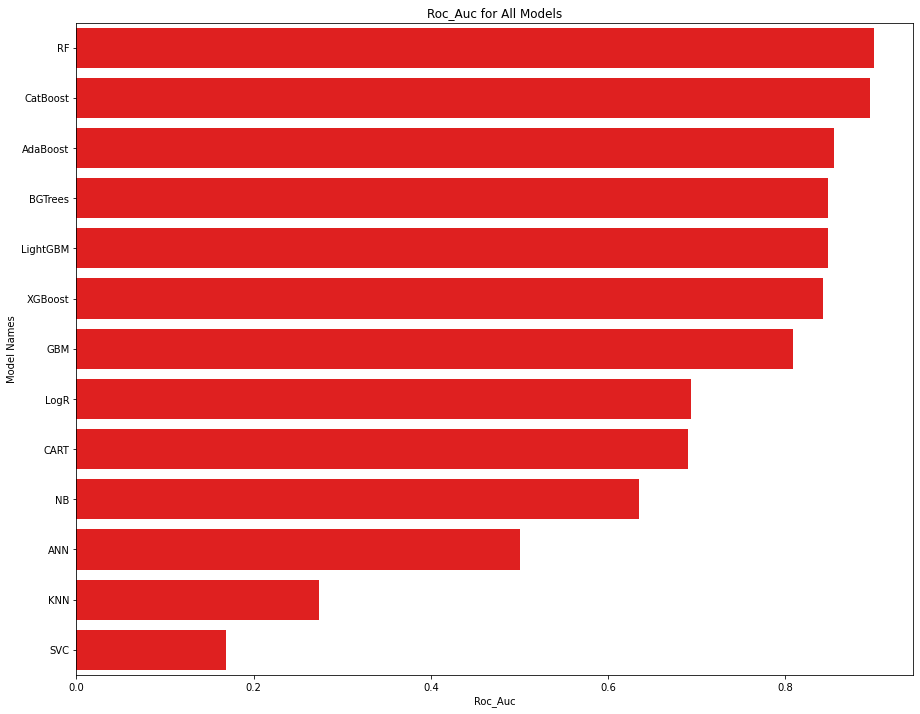

In [39]:
model_results = create_base_model(df, "potential_label", test_size=0.20, cv=10, plot=True, save_results=True)

# Create Model Tuned

In [46]:
def create_model_tuned(dataframe, target, test_size=0.20, cv=10, plot=False, save_results=False):
  names = []
  acc_results = []
  acc_train_results = []
  acc_test_results = []
  r2_results = []
  r2_train_results = []
  r2_test_results = []
  cv_results_acc = []
  cv_results_f1 = []
  cv_results_roc_auc = []
  best_params = []

  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=17)

  knn_params = {"n_neighbors": np.arange(1,50,1)}

  svc_params = {"C": np.arange(1,20)}

  ann_params = {"alpha": [0.1, 0.01, 0.001, 0.2],
                "hidden_layer_sizes": [(50,50,50), (100,100,100), (200,200,200)],
                "solver": ["adam","sgd"],
                "activation": ["relu","logistic"]}

  cart_params = {"max_depth": list(range(1,20)),
                 "min_samples_split": list(range(2,50))}

  rf_params = {"max_depth": [2,5,8,10],
               "max_features": [2,5,8],
               "n_estimators": [500,1000],
               "min_samples_split": [5,10]}

  adaboost_params = {"learning_rate": [0.1,0.01,0.001],
                     "n_estimators": [50,100,500,1000]}

  bgtrees_params = {"max_samples": [1,2,5,8,10],
                    "max_features": [1,2,5,8],
                    "n_estimators": [10, 50, 100,500]}

  gbm_params = {"learning_rate": [0.1,0.01,0.001],
                "n_estimators": [100,500,1000],
                "max_depth": [3,5,10],
                "min_samples_split": [2,5,10]}

  xgboost_params = {"n_estimators": [500,1000,2000],
                   "subsample": [0.6,0.8,1],
                   "max_depth": [4,5,6],
                   "learning_rate": [0.1,0.01,0.001],
                   "min_samples_split": [2,5,10]}

  lightgbm_params = {"n_estimators": [500,1000,2000],
                     "subsample": [0.6,0.8,1],
                     "max_depth": [4,5,6],
                     "learning_rate": [0.1,0.01,0.001],
                     "min_child_samples": [5,10,20]}

  catboost_params = {"iterations": [200,500],
                     "learning_rate": [0.1,0.01,0.001],
                     "depth": [3,5,8]}

  rs = 123
  models = [("KNN", KNeighborsClassifier(), knn_params),
            ("SVC", SVC(random_state=rs), svc_params),
            ('ANN', MLPClassifier(random_state=rs), ann_params),
            ('CART', DecisionTreeClassifier(random_state=rs), cart_params),
            ('RF', RandomForestClassifier(random_state=rs), rf_params),
            ("AdaBoost", AdaBoostClassifier(random_state=rs), adaboost_params),
            ('BGTrees', BaggingClassifier(bootstrap_features=True, random_state=rs), bgtrees_params),
            ('GBM', GradientBoostingClassifier(random_state=rs), gbm_params),
            ("XGBoost", XGBClassifier(objective='reg:squarederror', random_state=rs), xgboost_params),
            ("LightGBM", LGBMClassifier(random_state=rs), lightgbm_params),
            ("CatBoost", CatBoostClassifier(verbose=False, random_state=rs), catboost_params)]

  for name, classifier, params in models:
    gs_best = GridSearchCV(classifier, params, cv=3, n_jobs=-1, verbose=False).fit(X_train, y_train)
    final_model = classifier.set_params(**gs_best.best_params_).fit(X_train, y_train)
    # Acc Score
    acc = accuracy_score(y, final_model.predict(X))
    acc_train = accuracy_score(y_train, final_model.predict(X_train))
    acc_test = accuracy_score(y_test, final_model.predict(X_test))
    acc_results.append(acc)
    acc_train_results.append(acc_train)
    acc_test_results.append(acc_test)

    # R2 Score
    r2 = final_model.score(X, y)
    r2_train = final_model.score(X_train, y_train)
    r2_test = final_model.score(X_test, y_test)
    r2_results.append(r2)
    r2_train_results.append(r2_train)
    r2_test_results.append(r2_test)

    # Cross Validate Score
    cv_result = cross_validate(final_model, X, y, cv=cv, scoring=["accuracy", "f1", "roc_auc"])
    cv_result_acc = cv_result["test_accuracy"].mean()
    cv_result_f1 = cv_result["test_f1"].mean()
    cv_result_roc_auc = cv_result["test_roc_auc"].mean()
    cv_results_acc.append(cv_result_acc)
    cv_results_f1.append(cv_result_f1)
    cv_results_roc_auc.append(cv_result_roc_auc)

    # Best Params
    best_params.append(gs_best.best_params_)

    # Model names
    names.append(name)
  
  model_results = pd.DataFrame({'Model_Names': names,
                                'Acc': acc_results,
                                'Acc_Train': acc_train_results,
                                'Acc_Test': acc_test_results,
                                'R2': acc_train_results,
                                'R2_Train': r2_train_results,
                                'R2_Test': r2_test_results,
                                'CV_Acc': cv_results_acc,
                                'CV_f1': cv_results_f1,
                                'CV_roc_auc': cv_results_roc_auc,
                                'best_params': best_params
                                }).set_index("Model_Names")
  model_results=model_results.sort_values(by="CV_roc_auc", ascending=False)
  print(model_results)

  if plot:
    plt.figure(figsize=(15, 12))
    sns.barplot(x='CV_roc_auc', y=model_results.index, data=model_results, color="r")
    plt.xlabel('Roc_Auc')
    plt.ylabel('Model Names')
    plt.title('Roc_Auc for All Models')
    plt.show()
  
  if save_results:
    model_results.to_csv("model_results.csv")
  
  return model_results

               Acc  Acc_Train  Acc_Test     R2  R2_Train  R2_Test  CV_Acc  CV_f1  CV_roc_auc                                        best_params
Model_Names                                                                                                                                    
CatBoost    0.9041     0.9259    0.8182 0.9259    0.9259   0.8182  0.8743 0.5648      0.8953  {'depth': 5, 'iterations': 200, 'learning_rate...
RF          0.9336     0.9630    0.8182 0.9630    0.9630   0.8182  0.8743 0.5779      0.8937  {'max_depth': 8, 'max_features': 5, 'min_sampl...
LightGBM    0.8745     0.8981    0.7818 0.8981    0.8981   0.7818  0.8706 0.5438      0.8745  {'learning_rate': 0.001, 'max_depth': 4, 'min_...
XGBoost     0.9041     0.9259    0.8182 0.9259    0.9259   0.8182  0.8077 0.5151      0.8674  {'learning_rate': 0.001, 'max_depth': 4, 'min_...
GBM         0.9668     1.0000    0.8364 1.0000    1.0000   0.8364  0.8267 0.5138      0.8292  {'learning_rate': 0.1, 'max_depth': 5, 'mi

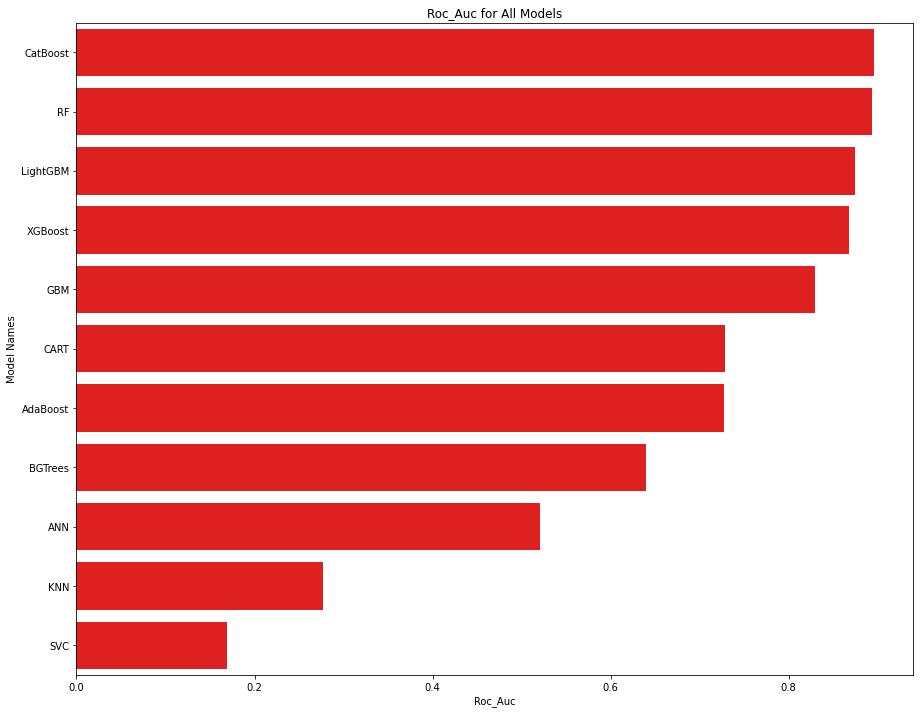

In [47]:
model_results = create_model_tuned(df, "potential_label", test_size=0.20, cv=10, plot=True, save_results=True)